In [1]:
%matplotlib inline

import numpy as np
import os


import matplotlib.image as img
import matplotlib.pyplot as plt

#Used to build up arrays quickly instead of manual values
from numpy import r_

from scipy.fftpack import dct, idct

from skimage import io, color, util
from skimage import exposure
from skimage.util import img_as_float32 as img_as_float
from skimage.util import img_as_ubyte as img_as_ubyte
from skimage.util import img_as_int as img_as_int

from PIL import Image

from IPython.display import display, Markdown

In [2]:
# Function to dislay images with title    
def show_images(I, titles=None):
    fig, ax = plt.subplots(1, len(I), figsize=(12,12))
    
    for i in np.arange(0,len(I)):
        ax[i].imshow(I[i], cmap='gray')
        ax[i].set_axis_off()
        if titles != None:
            ax[i].set_title(titles[i])

            
# Function used to display file size
def getStats(I):
# Get the file size
    file_size = os.path.getsize(I)
    return file_size

In [3]:
# Discrete Cosine Transform   (A Lossy compression technique)

# Takes two inputs an image and a Threshold value
def DiscreteCosineTransform(I, T):

#get size of image and create an empty array of that size    
    Isize = I.shape
    x = np.zeros(Isize)

# Performs an 8x8 block-wise DCT on the image. It iterates over the image
# DCT is applied along both the rows and columns of each block.
# DCT is applied twice in order to create a 2D DCT
# Process is very similar to the DFT (Discrete FOurier Transform)
# DFT uses a set of harmonically-related complex exponential functions 
# DCT uses only (real-valued) cosine functions.
#iterate over blocks of size 8x8 in the input image
    for i in r_[:Isize[0]:8]: # Iterates over rows of the image, incrementing by 8 
        for j in r_[:Isize[1]:8]:# Iterates over columns of the image, also incrementing by 8
            x[i:(i+8),j:(j+8)] = dct(dct( ( I[i:(i+8),j:(j+8)] ), axis=0, norm='ortho' ), axis=1, norm='ortho' ) #Within each block, apply DCT to corresponding 8x8 block of the input image.
            
# Threshold
# Applies a thresholding condition to the DCT coefficients. Coefficients below the threshold are set to zero.
# This is what affects the quality of output image, higher threshold means lower quality but higher compression
# Uses value stored in array x and creates new array
# which is the result of x multipled by a mask
# mask compares the absolute values of x with a threshold value, scaled by the maximum value in x. 
# Only the DCT coefficients that exceed the threshold are kept, others are set to zero.
    threshold = T 
    dct_threshold = x * (abs(x) > (threshold*np.max(x)))
    
    y = np.zeros(Isize)

# applies the inverse DCT (IDCT) on the thresholded coefficients to reconstruct the compressed image 
# iterates over the image in 8x8 blocks and applies the 2D IDCT
# Similar to 2D IDFT
# same concept as above but with IDCT
    for i in r_[:Isize[0]:8]:
        for j in r_[:Isize[1]:8]:
            y[i:(i+8),j:(j+8)] = idct(idct( ( dct_threshold[i:(i+8),j:(j+8)] ), axis=0 , norm='ortho'), axis=1 , norm='ortho')



# saves compressed file to directory and makes available to gather file size
    io.imsave('outputDCT.jpg', y)
    return y


In [4]:
# Run Length Encoding

# works best when a lot of pixels are repeated 
# remaps repeated pixels, for example insted AAAAAAA
# can do A6 which means A repeated six times
#Doesn't work too well for complex images with a lot of color and may even cause the compressed picture to increase in size

# Perform RLE on input Array
#loops through array till end, finds number of consqeutive elements and increments counter
#e = element, c= count
def run_length_encode(a):
    i =0
    j = ""
    while i<len(a):
        c=0
        e = a[i]
        while i<len(a) and  abs(a[i]-e)<=10 :
            c+=1
            i+=1
        
        e_bin = "{0:08b}".format(e) #makes into binary strings of 8 bits
        c_bin = "{0:08b}".format(c)
        j = j + e_bin + c_bin       #adds strings together representing the run-length encoded version of the input array.
    return j

# Compress the image using run-length encoding and save the compressed data to a file for decoding.
# creates to file to write to
# itterates over each row of array and perform run length encoding of each row
# writes the encoding string l to file
def compress_image(img_ar, filename):
    file = open(filename,"w")
    W, H = img_ar.shape
    bits=0
    for row in img_ar:
        l = run_length_encode(row) + '\n'
        file.write(l)
    file.close()
    return img_ar.shape

# Decode the compressed data from a file and reconstruct the image.
# Opens created file to read from
def decode( filename, W, H ):
    file = open(filename,"r+") 
    extract = file.read().split('\n')
    ar= [] # empty list to store decoded values
    for li in extract:      #iterates over each line (li) in the extract list
        for i in range(0,len(li),16): #iterates over the line with a step size of 16, representing each encoded value pair
            e = li[i:i+8] #extracts the first 8 characters (e) as the element
            c = li[i+8:i+16] #extracts he next 8 characters (c) as the count
            e = int(e,2)  # converts binary to int
            c = int(c,2)
            ar = ar+ c*[e] 
# closes the file
# converts list ar into numpy array and coverts it to original image size
# converts to unsigned int
# Then forms an image from that array and returns that image
    file.close()
    new_img = np.array(ar)
    new_img = np.reshape(new_img , (W, H))
    new_img = new_img.astype('uint8')
    new_img = Image.fromarray(new_img)
    return  new_img

# Combines all together to compress an image using run-length encoding
def rle(input_path):
    img = Image.open(input_path)
    img_ar = np.array(img)
    W, H = compress_image(img_ar, 'encode.txt')
    new_img = decode('encode.txt', W, H)
    new_img.save("whiteRLE.jpg")
    return new_img


In [5]:
# Discrete Cosine Transform   (A more complex Loseless compression technique)





Lossy conversion from float64 to uint8. Range [-0.11473068189839578, 1.118484691286424]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\dc559\AppData\Local\Temp\ipykernel_6412\2762481745.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
  while i<len(a) and  abs(a[i]-e)<=10 :
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


### Original. File Size: 4326 bytes

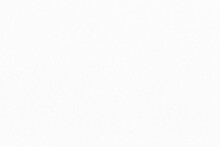

### RLE compressed. File Size: 814 bytes

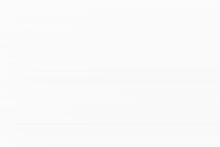

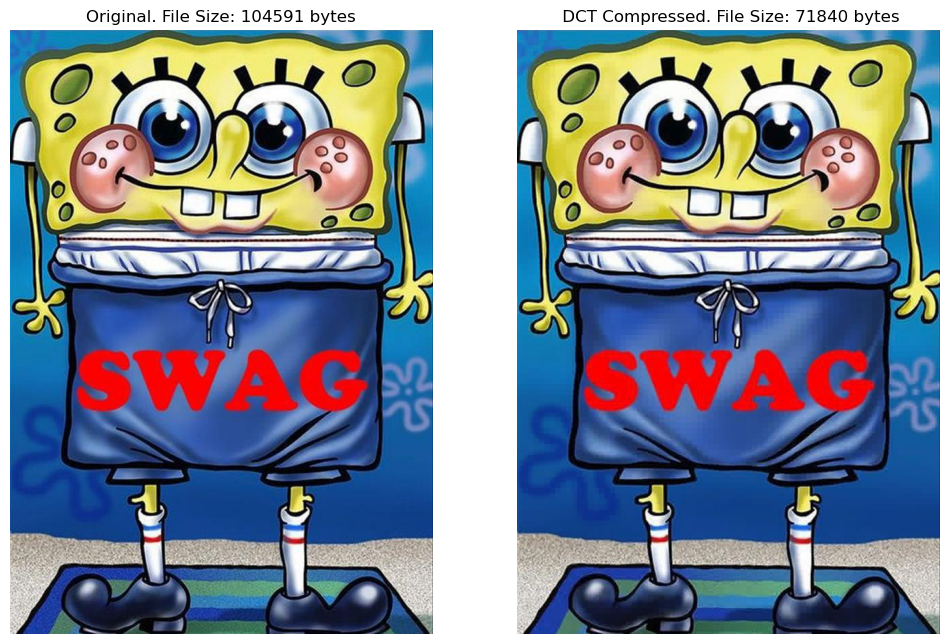

In [6]:
# Load the original spongebob JPEG image (skimage)
I = io.imread('input.jpg')
I1 = img_as_float(I)

# Load the original white JPEG image (PIL)
I3 = Image.open('white.jpg')


#implement DCT of spongebob image
#For T,  low values such as 0.014 create a good compression with low detail loss, 
# choosing 0.020 will be more compressed but have higher detail loss etc.
I2= DiscreteCosineTransform(I1,0.014)

#implement RLE of white image
I4= rle('white.jpg')

#Get file size of images
I1size= getStats('input.jpg')
I2size= getStats('outputDCT.jpg')
I3size= getStats('white.jpg')
I4size= getStats('whiteRLE.jpg')
#I3size= getStats('outputRunLength.jpg')


#Output DCT
show_images([I1, I2],[f'Original. File Size: {I1size} bytes', f' DCT Compressed. File Size: {I2size} bytes'])

#Output RlE
display(Markdown(f'### Original. File Size: {I3size} bytes'))
display(I3)
display(Markdown(f'### RLE compressed. File Size: {I4size} bytes'))
display(I4)

